# **TabNet** 

## **라이브러리 및 데이터 불러오기**

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

from matplotlib import pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from pytorch_tabnet.tab_model import TabNetClassifier

In [2]:
#!pip install "git+https://github.com/dreamquark-ai/tabnet.git@develop#egg=pytorch_tabnet" --upgrade

In [3]:
train=pd.read_csv('../train.csv')
test=pd.read_csv('../test.csv')
train=train.drop('FRST_RCV_DT', axis=1)
test=test.drop('FRST_RCV_DT', axis=1)
target='FDS_CATH'

In [4]:
print(train.shape)
print(test.shape)

(118888, 22)
(17661, 22)


In [5]:
print(train['FDS_CATH'].value_counts()/len(train))

0    0.969812
1    0.030188
Name: FDS_CATH, dtype: float64


In [6]:
print(test['FDS_CATH'].value_counts()/len(test))

0    0.987034
1    0.012966
Name: FDS_CATH, dtype: float64


## **train 데이터 정제**

In [7]:
nunique = train.nunique()
types = train.dtypes

categorical_columns=[]
categorical_dims ={}

for col in train.columns:
    if types[col] == 'object' or nunique[col] <200:
        l_enc= LabelEncoder()
        train[col]= train[col].fillna("VV_likely")
        train[col]= l_enc.fit_transform(train[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        train.fillna(train.loc[train_indices, col].mean(), inplace=True)

## **데이터 전처리 및 모델링**

In [9]:
features =[col for col in train.columns if col not in [target]]
cat_idxs = [i for i, f in enumerate(features) if f in categorical_columns]
cat_dims = [categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

In [10]:
train_x=train[features].values
train_y=train[target].values

In [10]:
clf=TabNetClassifier(cat_idxs=cat_idxs,
                    cat_dims=cat_dims,
                     cat_emb_dim=10, 
                     optimizer_fn = torch.optim.Adam, 
                     optimizer_params=dict(lr=1e-2),
                     scheduler_params={'step_size':50, "gamma":0.9},
                     scheduler_fn = torch.optim.lr_scheduler.StepLR, 
                     mask_type = 'sparsemax' #sparsemax, entmax
                    )

Device used : cpu


In [12]:
folds=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
max_epochs=10

for n_fold, (train_index, val_index) in enumerate(folds.split(train_x, train_y)):
    
    print(f"========================{n_fold+1}=================================")
    X_train, X_val = train_x[train_index], train_x[val_index]
    y_train, y_val = train_y[train_index], train_y[val_index]
    
    clf.fit(X_train=X_train, y_train=y_train,
           eval_set=[(X_train, y_train), (X_val, y_val)],
           eval_name=['train', 'valid'],
            eval_metric=['auc'],
            max_epochs=max_epochs, patience=20, batch_size=1024, virtual_batch_size =128, num_workers=1, weights=1, drop_last=False,
           )
             
    PATH='/home/users/adk8400153/AXA_FDS/tabnet_model/clf_'+str(n_fold) +'.pth'
    torch.save(clf, PATH)

========================1=================================
epoch 0  | loss: 0.66676 | train_auc: 0.64617 | valid_auc: 0.64208 |  0:00:34s
epoch 1  | loss: 0.60135 | train_auc: 0.73032 | valid_auc: 0.72319 |  0:01:09s
epoch 2  | loss: 0.58553 | train_auc: 0.74897 | valid_auc: 0.7424  |  0:01:43s
epoch 3  | loss: 0.57647 | train_auc: 0.75947 | valid_auc: 0.74854 |  0:02:16s
epoch 4  | loss: 0.56679 | train_auc: 0.76648 | valid_auc: 0.74078 |  0:04:24s
epoch 5  | loss: 0.5624  | train_auc: 0.77183 | valid_auc: 0.7438  |  0:06:14s
epoch 6  | loss: 0.56098 | train_auc: 0.77111 | valid_auc: 0.74529 |  0:06:53s
epoch 7  | loss: 0.5603  | train_auc: 0.77573 | valid_auc: 0.74594 |  0:07:27s
epoch 8  | loss: 0.56183 | train_auc: 0.77529 | valid_auc: 0.74631 |  0:07:59s
epoch 9  | loss: 0.55852 | train_auc: 0.78046 | valid_auc: 0.75397 |  0:08:31s
Stop training because you reached max_epochs = 10 with best_epoch = 9 and best_valid_auc = 0.75397
Best weights from best epoch are automatically used!

## **test data 정제**

In [11]:
#nunique = train.nunique()
#types = train.dtypes

categorical_columns=[]
categorical_dims ={}

for col in test.columns:
    if types[col] == 'object' or nunique[col] <200:
        l_enc= LabelEncoder()
        test[col]= test[col].fillna("VV_likely")
        test[col]= l_enc.fit_transform(test[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        test.fillna(test.loc[:, col].mean(), inplace=True)
        

test_x=test[features].values
test_y=test[target].values

## **test 결과 확인**

In [15]:
#test 정답 도출
test_prediction=np.zeros((test.shape[0], 2))
for n_fold in range(5):
    PATH='/home/users/adk8400153/AXA_FDS/tabnet_model/clf_'+str(n_fold)+'.pth'
    model=torch.load(PATH)
    test_prediction += model.predict_proba(test_x)/5

AUC score: 0.7707206893511105
precision score:0.030148706457526993
recall score: 0.6462882096069869


Text(0.5, 24.0, 'Predicted label')

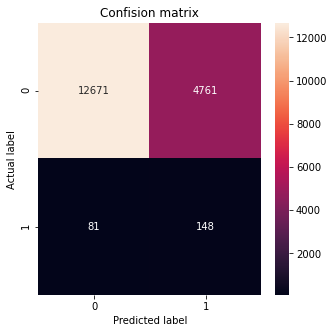

In [16]:
test_preds=np.argmax(test_prediction, axis=1)
print(f'AUC score: {roc_auc_score(y_score=test_prediction[:,1], y_true=test_y)}')
print(f'precision score:{precision_score(test_y, test_preds)}')
print(f'recall score: {recall_score(test_y, test_preds)}')
cm=confusion_matrix(test_y, test_preds)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confision matrix")
plt.ylabel("Actual label")
plt.xlabel("Predicted label")

In [17]:
test_prediction

array([[0.44119745, 0.5588025 ],
       [0.52171519, 0.47828484],
       [0.96931471, 0.03068523],
       ...,
       [0.43793021, 0.56206978],
       [0.62986757, 0.37013246],
       [0.40504406, 0.59495595]])

In [18]:
test_prediction=pd.DataFrame(test_prediction, columns=['p0', 'p1'])
score=pd.concat([test[[target]], test_prediction['p1']], axis=1)
score.sort_values('p1', ascending=False, inplace=True)
score=score.reset_index().drop('index', axis=1).copy()

In [19]:
n_group=10
group=['G01','G02','G03','G04','G05','G06','G07','G08','G09','G10']
bins=round(len(score)/n_group)
bins_1=len(score)-bins*(n_group-1)

group_list=[]
for i in range(n_group):
    if i <n_group-1:
        group_list.append(np.repeat(group[i], bins).tolist())
    else:
        group_list.append(np.repeat(group[i], bins_1).tolist())
    
import itertools
group_list=list(itertools.chain(*group_list))
score['group']=pd.Series(group_list)

function_list=['count','sum','mean']
table=score.groupby(['group']).agg(function_list).reset_index()

In [20]:
table

group FDS_CATH                   p1                       
           count  sum      mean count          sum      mean
0   G01     1766  100  0.056625  1766  1261.402540  0.714271
1   G02     1766   27  0.015289  1766  1031.645325  0.584171
2   G03     1766   26  0.014723  1766   918.559120  0.520135
3   G04     1766   17  0.009626  1766   810.002935  0.458665
4   G05     1766   20  0.011325  1766   719.761679  0.407566
5   G06     1766   15  0.008494  1766   643.981311  0.364655
6   G07     1766   10  0.005663  1766   520.157844  0.294540
7   G08     1766    8  0.004530  1766   363.617320  0.205899
8   G09     1766    2  0.001133  1766   176.670194  0.100040
9   G10     1767    4  0.002264  1767    62.001602  0.035089

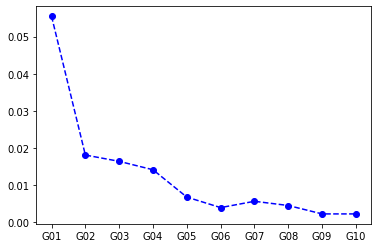

In [15]:
plt.plot(table['group'], table['FDS_CATH']['mean'],'bo--')

## **시각화**

Text(0, 0.5, 'sample number')

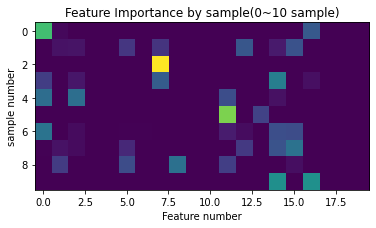

In [69]:
final_masks=np.zeros((masks[0].shape[0], masks[0].shape[1] ))
for i in range(3):
    final_masks +=masks[0]
plt.imshow(final_masks[:10])
plt.title("Feature Importance by sample(0~10 sample)")
plt.xlabel("Feature number")
plt.ylabel("sample number")

In [46]:
final_masks_percent=np.sum(final_masks, axis=0)

In [65]:
np.set_printoptions(precision=6, suppress=True)
final_masks_percent/ np.sum(final_masks_percent)

array([0.112878, 0.06245 , 0.047573, 0.000051, 0.      , 0.058923,
       0.005204, 0.102737, 0.00198 , 0.000268, 0.000359, 0.20544 ,
       0.017121, 0.018686, 0.181641, 0.01779 , 0.143759, 0.000602,
       0.000031, 0.022506])

# **train 결과 도출**

In [22]:
#train 정답 도출
train_prediction=np.zeros((train.shape[0], 2))
for n_fold in range(5):
    PATH='/home/users/adk8400153/AXA_FDS/tabnet_model/clf_'+str(n_fold)+'.pth'
    model=torch.load(PATH)
    train_prediction += model.predict_proba(train_x)/5

AUC score: 0.8020582225852022
precision score:0.07696344776488022
recall score: 0.6946224575090555


Text(0.5, 24.0, 'Predicted label')

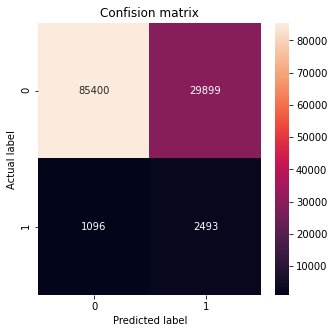

In [23]:
train_preds=np.argmax(train_prediction, axis=1)
print(f'AUC score: {roc_auc_score(y_score=train_prediction[:,1], y_true=train_y)}')
print(f'precision score:{precision_score(train_y, train_preds)}')
print(f'recall score: {recall_score(train_y, train_preds)}')
cm=confusion_matrix(train_y, train_preds)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confision matrix")
plt.ylabel("Actual label")
plt.xlabel("Predicted label")

In [24]:
train_prediction=pd.DataFrame(train_prediction, columns=['p0', 'p1'])
score=pd.concat([train[[target]], train_prediction['p1']], axis=1)
score.sort_values('p1', ascending=False, inplace=True)
score=score.reset_index().drop('index', axis=1).copy()

In [25]:
n_group=10
group=['G01','G02','G03','G04','G05','G06','G07','G08','G09','G10']
bins=round(len(score)/n_group)
bins_1=len(score)-bins*(n_group-1)

group_list=[]
for i in range(n_group):
    if i <n_group-1:
        group_list.append(np.repeat(group[i], bins).tolist())
    else:
        group_list.append(np.repeat(group[i], bins_1).tolist())
    
import itertools
group_list=list(itertools.chain(*group_list))
score['group']=pd.Series(group_list)

function_list=['count','sum','mean']
table=score.groupby(['group']).agg(function_list).reset_index()

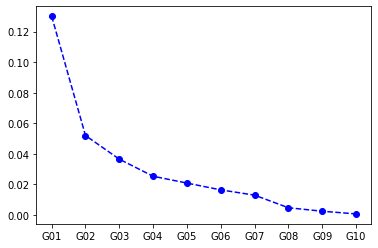

In [26]:
plt.plot(table['group'], table['FDS_CATH']['mean'],'bo--')

In [27]:
table

group FDS_CATH                     p1                       
           count   sum      mean  count          sum      mean
0   G01    11889  1546  0.130036  11889  8733.102717  0.734553
1   G02    11889   618  0.051981  11889  7058.496841  0.593700
2   G03    11889   434  0.036504  11889  6157.437067  0.517910
3   G04    11889   301  0.025318  11889  5391.203836  0.453462
4   G05    11889   248  0.020860  11889  4824.293944  0.405778
5   G06    11889   195  0.016402  11889  4351.556794  0.366015
6   G07    11889   154  0.012953  11889  3546.225304  0.298278
7   G08    11889    56  0.004710  11889  2592.743098  0.218079
8   G09    11889    29  0.002439  11889  1196.603926  0.100648
9   G10    11887     8  0.000673  11887   377.677037  0.031772